# Capstone Project: Insurance Renewal Propensity Model #
This is a data science portfolio for solving the insurance use case. The dataset used in this project is sourced from the data science competition sponsored by the McKinsey analytics consulting firm.
The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon-4/).

**Goal:** 
1. To develop a classification model which predicts clients at high probabilities of renewing their policies
2. To create an incentive plan to maximize net revenues collected from policy holders

**Results:**
83% of auc_roc score made on test set of client population using Random Forest classifier.

**Risks:**
Model incorrectly identified with 17% of auc_roc error on test set.

**Mitigation:**
Review identified cases with senior management and sales agents before any making incentive plans

**Next Steps for Future Work:**
* Collection of meaningful features.
* Model improvement: algorithms, resampling strategies and etc.

**Recommendations for Companies:**
* Option 1
* Option 2

## Part 1 - DEFINE ##

**Problem Statement:**  
an insurance company needs the data scientist's help in building a model to predict the propensity for paying renewal premium and build an incentive plan for its agents to maximize the total net revenue (i.e., incentives provided to collect renewal premiums) from their policyholders (clients).

The insurance propensity dataset comes with information about the policyholders' demographics and aggregated past historical transaction data like # of premiums paid on time, # of premiums paid late, client sourcing channel etc.

In addition to the above information, the insurance company provided the following relationships:

1. The equation for the effort in hours puts by an agent for incentives provided;
2. The equation for the expected improvement in renewal probabilities, given the effort from the agent.

**Stakeholders:** 
* Insurance company senior management
* Insurance company sales agents
* Insurance policy holders - clients

In [1]:
# Import all libraries #
import itertools
import sys
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('ggplot')
import operator
from itertools import cycle
import scipy.stats as sp
from scipy import interp
from scipy.stats import randint
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm
import sklearn.base as skb
from sklearn.utils import shuffle, resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

C:\Users\yoots\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Part 2 - DISCOVERY ##

In [2]:
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_as_category(df):
    '''convert datatype from object to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')            

        
def drop_column(df, var_name):
    ''' drop a column on dataframe '''
    df = df.drop(var_name, axis=1)
    return df


def clean_data(raw_df):
    '''remove rows that contain outliers'''
    clean_df = raw_df.drop_duplicates(subset='id')
    return clean_df
    

def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def avg_groupby_data(cleaned_df, num_var, cat_var, avg_var_name):
    '''groupby categorical var to calculate an average numerical feature'''
    avg_groupby_cat_val = cleaned_df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_cat_df = pd.DataFrame({cat_var:list(cleaned_df[cat_var].unique()),
                                      avg_var_name:avg_groupby_cat_val})
    avg_groupby_cat_df.reset_index(drop=True, inplace=True)
    return avg_groupby_cat_df


def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapping values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]


def EDA_missing_data(df):
    ''' compute missing value % on a df'''
    df_missing = pd.DataFrame(df.isnull().sum())
    df_missing.columns = ['count']
    df_missing = df_missing.sort_values(by='count', ascending=False)
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def EDA_summary_stat_num(df):
    ''' compute numerical summary statistics '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def EDA_summary_stat_cat(df):
    ''' compute numerical summary statistics '''
    df_stat_cat = pd.DataFrame(df.describe(include='category').T)
    return df_stat_cat


def EDA_feature_importance_plot(model, X, y):
    '''plots the feature importance plot on trained model'''
    model = model
    model.fit(X, y)
    feat_labels = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90, fontsize=7)
    plt.xlim(-1, X.shape[1])


def feature_replacement(X):
    ''' replace missing values based on specific data type of a column '''
    for col in X.columns:
        if X[col].dtype.name == 'object':
            mode = X[col].mode().iloc[0]
            X[col] = X[col].fillna(mode)
        elif X[col].dtype.name == 'float64':
            mean = X[col].mean()
            X[col] = X[col].fillna(mean)
        else:
            X[col].dtype.name == 'int64'
            median = X[col].median()
            X[col] = X[col].fillna(median)


def apply_binning(df, new_var, old_var, bins, labels):
    '''apply binning on a selected variable'''
    df[new_var] = pd.cut(df[old_var], bins=bins,
                          labels=labels, include_lowest=True)
    return df[new_var]


def one_hot_encode_feature(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and
       combine results with numerical variables '''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)


def get_label_data(df, label_var):
    '''separate label from a dataframe'''
    df_label = df[label_var]
    return df_label


def feature_scale_data(X):
    '''Feature scaled data based on standardization'''
    sc_X = StandardScaler()
    X_std = sc_X.fit_transform(X)
    return X_std
    

def score_model_roc_auc(model, X_train, y_train, X_val, y_val):
    '''computes the roc_auc score for probability of being a stroke case'''
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    return skm.roc_auc_score(y_val, probs[:,1])


def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''performs RandomizedSearchCV to tune model hyper-parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search


def print_best_param(random_search, param_1=None, param_2=None, param_3=None, param_4=None):
    '''print the best model parameter(s)'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])
    print("Best " + param_4 + ":", random_search.best_estimator_.get_params()[param_4])


def model_train(model, feature_df, label_df, n_proc, mean_roc_auc, cv_std):
    '''train a model and output mean roc_auc and CV std.dev roc_auc'''
    roc_auc = cross_val_score(model, feature_df, label_df, n_jobs=n_proc,
                               cv=5, scoring='roc_auc')
    mean_roc_auc[model] = np.mean(roc_auc)
    cv_std[model] = np.std(roc_auc)    


def model_summary(model, mean_roc_auc, cv_std):
    '''print out the model performances'''
    print('\nModel:\n', model)
    print('Average roc_auc:\n', mean_roc_auc[model])
    print('Std. Dev during CV:\n', cv_std[model])    


def compute_confusion_matrix(y_act, y_pred):
    '''compute sklearn confusion matrix'''
    cm_model = skm.confusion_matrix(y_act, y_pred)
    return cm_model  


def plot_confusion_matrix(cm, classes):
    '''plot the confusion matrix of trained model'''
    fig, ax = plt.subplots(figsize=(7,7))
    cm = cm.astype('float')/cm.sum()
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')
    plt.xlabel('predicted label')
    plt.ylabel('true label')


def report_class_summary(model_name, y_act, y_pred):
    '''Write a classification summary report''' 
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred))
    
    
def model_results(model, mean_roc_auc, predictions, feature_importances):
    '''saves the model name, mean_roc_auc, predicted rate, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        predictions.to_csv('pred_results_best.csv', index=False)

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    train_file = 'insurance_train.csv'
    test_file = 'insurance_test.csv'

# Load data
df_train = load_file(train_file) 
df_test = load_file(test_file)
del(train_file, test_file)

# --- 3. ETL - metadata format --- #
# lower case column names:
df_train.columns = map(str.lower, df_train.columns)
df_test.columns = map(str.lower, df_test.columns)

# define variables:
var_label = 'renewal'
vars_cat = list(df_train.select_dtypes(include='O'))

# check data types on dataframe(s):
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
income                              79853 non-null int64
count_3-6_months_late               79756 non-null float64
count_6-12_months_late              79756 non-null float64
count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(6), object(2)
memory usage: 7.9+ MB


In [4]:
# --- 4. ETL - merging/subsetting data --- #
# create a dataframe with label:
df_label = df_train[['id','renewal']]

# drop a label:
df_train = drop_column(df_train, var_label)

# merge on a train set and label:
df_train_raw = join_data(df_train, df_label, 'inner', 'id')

# --- 5. ETL - cleaning data --- #
# clean data: train & test sets
df_train_clean = shuffle(clean_data(df_train_raw)).reset_index(drop=True) 
df_test_clean = shuffle(clean_data(df_test)).reset_index(drop=True)
del (df_test, df_train, df_train_raw)

# create a test set: 'id'
df_test_id = df_test_clean['id']

### Feature Imputation ###
Let's compute feature imputation to replace missing values by different types of variables/features: 
1. Mode: nominal variables
2. Mean: numerical variables
3. Median: ordinal variables

In [5]:
# --- 6. Feature Imputation --- #
# Compute missing value %: before replacement
df_missing_pre = EDA_missing_data(df_train_clean)
df_missing_pre

# feature imputation:
feature_replacement(df_train_clean)
feature_replacement(df_test_clean)

# Compute missing value %: after replacement
df_missing_post = EDA_missing_data(df_train_clean)
df_missing_post
del(df_missing_pre, df_missing_post)

### Feature Engineering ###
* Create a new feature using existing feature(s) with known business rules/knowledge.
* Also can use different types of transformation such as average and groupby.

In [6]:
# --- 7. Feature Engineering --- #
# Create a new feature: age converted in years
df_train_clean['age'] = round(df_train_clean['age_in_days']/365, 0)
df_test_clean['age'] = round(df_test_clean['age_in_days']/365, 0)

# Drop age_in_days from dataframe:
df_train_clean = drop_column(df_train_clean, 'age_in_days')
df_test_clean = drop_column(df_test_clean, 'age_in_days')

df_train_clean.info()

# average age by categorical variables:
#df_avg_income_by_src_channel = avg_groupby_data(df_train_clean, 'income',
#                                                'sourcing_channel', 'avg_income_src_channel')
## perform left joins on avg grouped dataframes:
#df_train_clean = join_data(df_train_clean, df_avg_income_by_src_channel, 'left', key='sourcing_channel')
#df_test_clean = join_data(df_test_clean, df_avg_income_by_src_channel, 'left', key='sourcing_channel')

# re-cap: numerical features
vars_num_disc = list(df_train_clean.select_dtypes(include='int64'))
vars_num_cont = list(df_train_clean.select_dtypes(include='float64'))

# concatenate a list:
vars_num = vars_num_disc + vars_num_cont

# delete a list of unwanted variables:
unwanted_list = {'id', 'renewal'}
vars_num = [var for var in vars_num if var not in unwanted_list]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79853 entries, 0 to 79852
Data columns (total 13 columns):
id                                  79853 non-null int64
perc_premium_paid_by_cash_credit    79853 non-null float64
income                              79853 non-null int64
count_3-6_months_late               79853 non-null float64
count_6-12_months_late              79853 non-null float64
count_more_than_12_months_late      79853 non-null float64
application_underwriting_score      79853 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
age                                 79853 non-null float64
dtypes: float64(6), int64(5), object(2)
memory usage: 7.9+ MB


In [7]:
# --- 8. Exploratory Data Analysis --- #
# perform numerical stat:
df_stat_num = EDA_summary_stat_num(df_train_clean[vars_num])
df_stat_num

# convert date type: object to category
convert_dt_as_category(df_train_clean)
convert_dt_as_category(df_test_clean)

# perform categorical stat:
df_stat_cat = EDA_summary_stat_cat(df_train_clean[vars_cat])
df_stat_cat

,count,unique,top,freq
sourcing_channel,79853,5,A,43134
residence_area_type,79853,2,Urban,48183


### One-Hot Encoding: Dummy Variables ###
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted the ML models for making accurate predictions.

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male vs. gender_other).

In [8]:
# --- 9. Prepare Training Data --- #
# Drop first dummy variable on each nominal feature to avoid dummy variable trap:
df_feature_enc = one_hot_encode_feature(df_train_clean, cat_vars=vars_cat, num_vars=vars_num)
df_test_enc = one_hot_encode_feature(df_test_clean, cat_vars=vars_cat, num_vars=vars_num)

# create a label:
label_df = df_train_clean['renewal']

# check % renewal: since 93.7% get renewal, no need to apply re-sampling technique here!
label_pct = pd.DataFrame(df_label.groupby('renewal')['renewal'].count())
label_pct['pct_renewal'] = (label_pct['renewal']/len(df_label)) * 100
label_pct['pct_renewal']

# delete dataframes:
del(df_train_clean, df_test_clean, df_label)

# --- 10. split data into train and test set --- # 
X_train, X_val, y_train, y_val = train_test_split(df_feature_enc, label_df, test_size=.3,
                                                    random_state=0, stratify=label_df)
# Check label counts on the split set:
print('class label counts in total:', np.bincount(label_df))
print('class label counts in train set:', np.bincount(y_train))
print('class label counts in test set:', np.bincount(y_val))

class label counts in total: [ 4998 74855]
class label counts in train set: [ 3499 52398]
class label counts in test set: [ 1499 22457]


In [9]:
## --- 11. Feature Selection --- #
## Baseline Prediction:
#baseline = RandomForestClassifier(n_estimators=100, n_jobs=-1)
#baseline.fit(X_train_std, y_train)
#
## Plot feature importances:
#EDA_feature_importance_plot(baseline, X_train, y_train)
#
## Make predicted probabilities:
#probs = baseline.predict_proba(X_test_std)
#
## compute a roc_auc score on positive cases only:
#skm.roc_auc_score(y_val, probs[:,1]) 
#
## basline predictions: test results
#test_probs = baseline.predict_proba(df_test_enc)
#
## save a dataframe: test results
#results = pd.DataFrame({'id':df_test_id,
#                        'renewal':test_probs[:,1]})
#    
#results.to_csv('pred_baseline.csv', index=False, index_label=None)
#del(baseline, probs, test_probs, results)

## Part 3 - DEVELOP ##

In [10]:
# --- 12. create models --- # 
# initialize model list and dicts
models = []
mean_roc_auc = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

## create and tune the models that you brainstormed during part 2
################################################################################        
## Hyper-parameters tuning: LogisticRegression
#lr = LogisticRegression()
#n_iter = 10
#param_dist_lr = dict(tol=np.random.uniform(0, 0.0001, 10), C=sp.randint(1,50),
#                     penalty=['l1', 'l2'], solver=['liblinear','saga'])
#random_search_lr = model_tuning_param(lr, X_train, y_train, param_dist_lr, n_iter)
#
## print the best model parameters: LogisticRegression    
#param_1 = 'tol'
#param_2 = 'C'
#param_3 = 'penalty'
#param_4 = 'solver'
#
#print_best_param(random_search_lr, param_1, param_2, param_3, param_4)
################################################################################        
## Hyper-parameters tuning: DecisionTree
#tree = DecisionTreeClassifier(criterion='gini', random_state=0)
#
#n_iter = 10
#param_dist_tree = {'max_depth': sp.randint(10,100),
#                 'min_samples_split': sp.randint(2,10),
#                 'min_samples_leaf': sp.randint(2,10),
#                 'max_features': sp.randint(2,10)}
#
#random_search_tree = model_tuning_param(tree, X_train, y_train, param_dist_tree, n_iter)
#
## print the best model parameters: DecisionTree    
#param_1 = 'max_depth'
#param_2 = 'min_samples_split'
#param_3 = 'min_samples_leaf'
#param_4 = 'max_features'
#
#print_best_param(random_search_tree, param_1, param_2, param_3, param_4)
################################################################################        
## Hyper-parameters tuning: RandomForest
#forest = RandomForestClassifier(criterion='gini', random_state=0)
#
#n_iter = 10
#param_dist_forest = {'n_estimators': sp.randint(10,100),
#                     'max_depth': sp.randint(10,100),
#                     'min_samples_split': sp.randint(2,10),
#                     'min_samples_leaf': sp.randint(2,10)}
#
#random_search_forest = model_tuning_param(forest, X_train, y_train, param_dist_forest, n_iter)
#
## print the best model parameters: RandomForest    
#param_1 = 'n_estimators'
#param_2 = 'max_depth'
#param_3 = 'min_samples_split'
#param_4 = 'min_samples_leaf'
#
#print_best_param(random_search_forest, param_1, param_2, param_3, param_4)
################################################################################    
## Hyper-parameters tuning: XGBoost
#xgb = XGBClassifier(random_state=0)
#n_iter = 10
#
#param_dist_xgb = {'n_estimators': sp.randint(10,100),
#                 'max_depth': sp.randint(10,100),
#                 'colsample_bytree': np.random.uniform(0, 1, 10),
#                 'learning_rate': np.random.uniform(0, 1, 10)}
#
#random_search_xgb = model_tuning_param(xgb, X_train, y_train, param_dist_xgb, n_iter)
#
## print the best model parameters: XGBoost    
#param_1 = 'n_estimators'
#param_2 = 'max_depth'
#param_3 = 'colsample_bytree'
#param_4 = 'learning_rate'
#
#print_best_param(random_search_xgb, param_1, param_2, param_3, param_4)
################################################################################  

In [11]:
# --- 13. cross-validate models --- # 
# a list of models to train: 5 fold cross-validation
lr = LogisticRegression(tol=8.354e-05, C=14, penalty='l1', solver='liblinear')
tree = DecisionTreeClassifier(max_depth=62, min_samples_split=9, min_samples_leaf=9,
                              max_features=6, random_state=0)
forest = RandomForestClassifier(n_estimators=77, max_depth=99, min_samples_split=2,
                                min_samples_leaf=9, random_state=0) 
xgb = XGBClassifier(n_estimators=96, max_depth=13, colsample_bytree=0.85227,
                    learning_rate=0.028697, random_state=0)

# a list of classifiers:
models.extend([lr, tree, forest, xgb])

# cross-validate models, using roc_auc to evaluate and print the summaries
print('begin cross-validation')
for model in models:
    model_train(model, X_train, y_train, n_proc, mean_roc_auc, cv_std)
    model_summary(model, mean_roc_auc, cv_std)
    
# --- 14. select the best model --- #
model = max(mean_roc_auc, key=mean_roc_auc.get)
print('\nBest model with the highest mean roc_auc:')
print(model)

begin cross-validation

Model:
 LogisticRegression(C=14, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=8.354e-05,
                   verbose=0, warm_start=False)
Average roc_auc:
 0.8250185833757477
Std. Dev during CV:
 0.007805805149215839

Model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=62,
                       max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Average roc_auc:
 0.7123110075822898
Std. Dev during CV:
 0.009608748662421325

Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, crite

### Model Evaluation: using Feature Selection ###
Compute a roc_auc score on "renewal cases" for following models:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

In [12]:
# --- compute a roc_auc score on "positive cases" --- #
score_model_roc_auc(lr, X_train,
                    y_train, X_val, y_val)

0.8393259931967529

### Model 1: Logistic Regression ###
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=stroke) ≥ 0.5, an observation is predicted as a stroke. Whereas if P(1=stroke) < 0.5, an observation is predicted as a non-stroke.

### Model 2: Decision Tree ###
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. Tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-stroke or stroke cases only).

### Model 3: Random Forest ###
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

### Model 4: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
1. True Positives (TP): These are cases in which model predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): Model predicted no, and they don't have the disease.
3. False Positives (FP): Model predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): Model predicted no, but they actually do have the disease. (Also known as a "Type II error.")

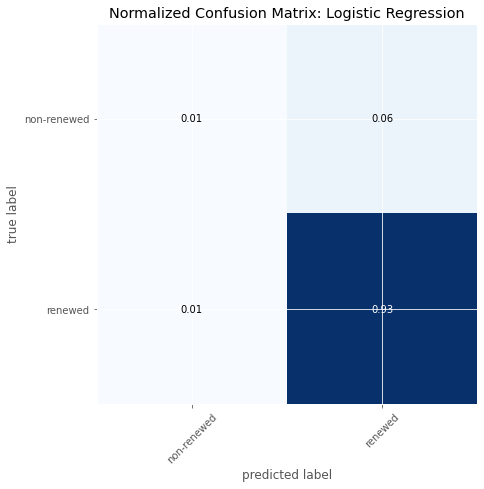

Accuracy of Logistic Regression is 0.94
Precision of Logistic Regression is 0.94
Recall of Logistic Regression is 0.99
ROC score of Logistic Regression is 0.56


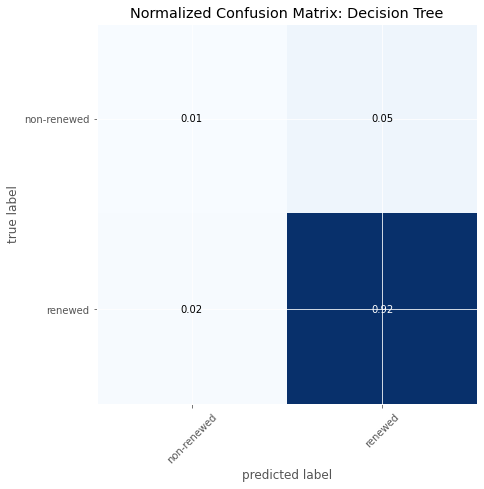

Accuracy of Decision Tree is 0.93
Precision of Decision Tree is 0.95
Recall of Decision Tree is 0.98
ROC score of Decision Tree is 0.58


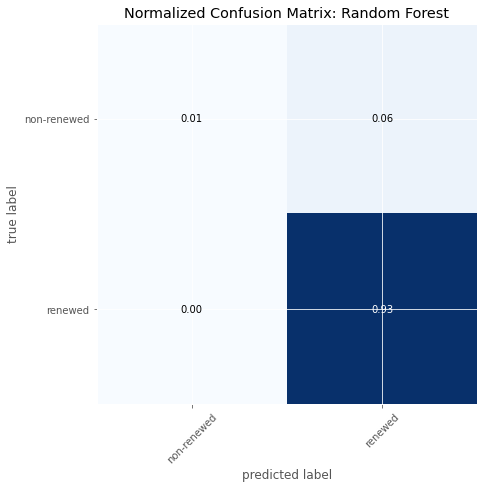

Accuracy of Random Forest is 0.94
Precision of Random Forest is 0.94
Recall of Random Forest is 1.00
ROC score of Random Forest is 0.55


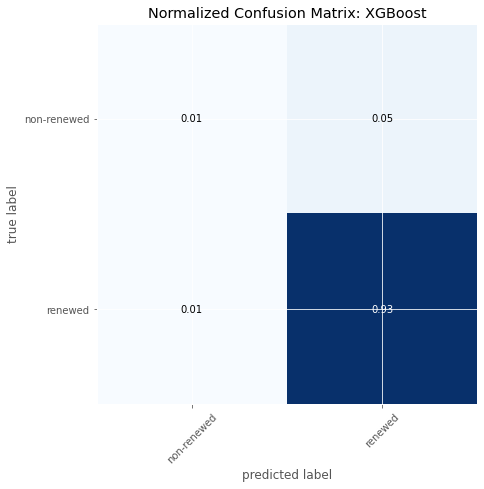

Accuracy of XGBoost is 0.94
Precision of XGBoost is 0.94
Recall of XGBoost is 0.99
ROC score of XGBoost is 0.56


In [13]:
# --- 15. Model Evaluation ---    
# compute predictions by a model:
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)

forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_val)

xgb.fit(X_train.values, y_train) # special for xgboost .values
y_pred_xgb = xgb.predict(X_val.values) # special for xgboost .values

# compute confusion matrices by a model:
cm_lr = compute_confusion_matrix(y_val, y_pred_lr)

cm_tree = compute_confusion_matrix(y_val, y_pred_tree)

cm_forest = compute_confusion_matrix(y_val, y_pred_forest)

cm_xgb = compute_confusion_matrix(y_val, y_pred_xgb)

# Define class labels for stroke:
class_labels = np.array(['non-renewed', 'renewed'], dtype=str)

#####################################################
# Confusion Matrix & Classification Metrics Summary #
#####################################################
# --- Model 1 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_lr, class_labels)
plt.title('Normalized Confusion Matrix: Logistic Regression')
plt.show()

# Report classification metrics summary:
report_class_summary('Logistic Regression', y_val, y_pred_lr)

# --- Model 2 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_tree, class_labels)
plt.title('Normalized Confusion Matrix: Decision Tree')
plt.show()

# Report classification metrics summary:
report_class_summary('Decision Tree', y_val, y_pred_tree)

# --- Model 3 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_forest, class_labels)
plt.title('Normalized Confusion Matrix: Random Forest')
plt.show()

# Report classification metrics summary:
report_class_summary('Random Forest', y_val, y_pred_forest)

# --- Model 4 --- #
# Plot a confusion matrix: 
plot_confusion_matrix(cm_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Report classification metrics summary:
report_class_summary('XGBoost', y_val, y_pred_xgb)

## Model Evaluation: ROC curve ##
ROC curve typically displays true positive rate on the Y-axis, and false positive rate on the X-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

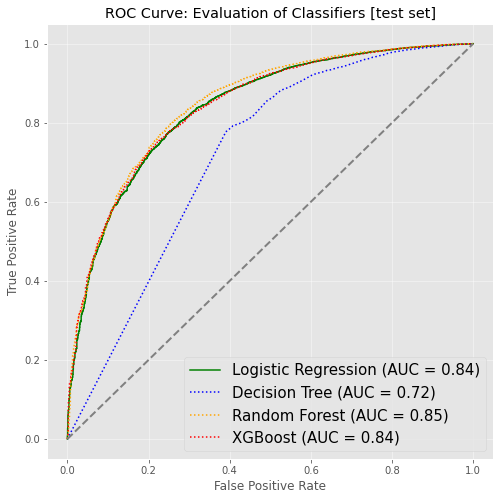

In [14]:
# --- 16. Model Plotting --- 
# ROC for each classifiers
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
all_clf = [lr, tree, forest, xgb]

# plot a ROC_AUC curve:
plt.figure(figsize=(8,8))
colors = ['green', 'blue', 'orange', 'red']
linestyles = ['-', ':', ':', ':'] 
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):  
        # Assume the label of the positive class is 1
        y_pred = clf.fit(X_train.values,y_train).predict_proba(X_val.values)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_val, y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (AUC = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: Evaluation of Classifiers [test set]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

### Summary of ROC Curve ###
This plot showed performance of all four models area under the curve. The best model had about AUC = 0.83 for random forest model. This indicated that about 83% of time model is good at separation of renewed cases from non-renewed cases.

## Model Evaluation: Precision-Recall Curve ##
Precision-Recall is a useful measure of success for predictions when the classes of dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In summary, a system with high recall but low precision returns: many predictions where most of prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average P-R score of Logistic Regression: 0.99


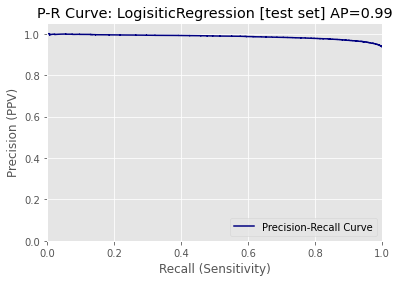

In [15]:
# compute avg. precision score:
y_score_lr = lr.fit(X_train,y_train).predict_proba(X_val.values)[:,1]
avg_precision = skm.average_precision_score(y_val, y_score_lr)
print('Average P-R score of Logistic Regression: {0:0.2f}'.format(avg_precision))

# plot a P-R curve:
precision, recall, _ =skm.precision_recall_curve(y_val, y_score_lr)
plt.step(recall, precision, color='navy', where='post', label='Precision-Recall Curve')
plt.title('P-R Curve: LogisiticRegression [test set] AP={0:0.2f}'.format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0, 1.05])
plt.xlim([0, 1.0])
plt.legend(loc='lower right')
plt.show()

### Summary of Precision-Recall Curve ###
Overall, the Logistic Regression showed weighted average precision of 0.98. In other words, about 98% of time, the model is good at making stroke predictions from total # of actual stroke cases.

## Part 4 - DEPLOY ##

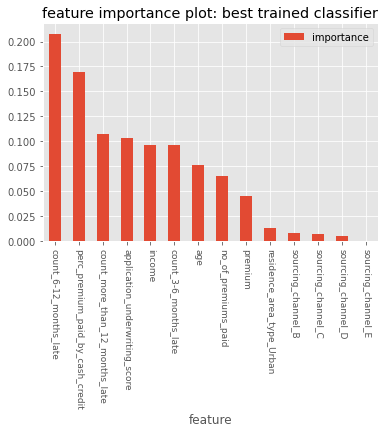

In [16]:
# --- 17. automate the model pipeline --- #
# make predictions on a test set:
df_pred_probs = forest.predict_proba(df_test_enc)
df_pred = forest.predict(df_test_enc)

# make predictions dataframe:
results = pd.DataFrame({'id':df_test_id,
                        'renewal':df_pred_probs[:,1]})
results.to_csv('prob_results_best.csv', index=False, index_label=None)

# --- 18. deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
# linear models don't have feature_importances_
    importances = [0]*len(X_train.columns)

# sort a dataframe by feature importance score: 
feature_importances = pd.DataFrame({'feature':X_train.columns,
                                        'importance':importances})
feature_importances.sort_values(by='importance', inplace=True, ascending=False)

# set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

# create a bar plot:    
feature_importances[0:15].plot.bar(align='center')
plt.xticks(rotation=270, fontsize=9)
plt.title('feature importance plot: best trained classifier')
plt.show()
    
# save model results as .csv file:
model_results(model, mean_roc_auc[model], results, feature_importances)

### Model Summary: Feature Importance ###
A figure showed that the feature importance on the best trained model from order of the highest to lowest score.
Top 10 important features are count of 6-12 months paid late, % premium paid by credit, etc.

## Part 5 - INCENTIVE PLAN ##

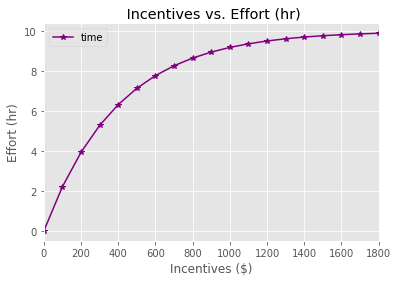

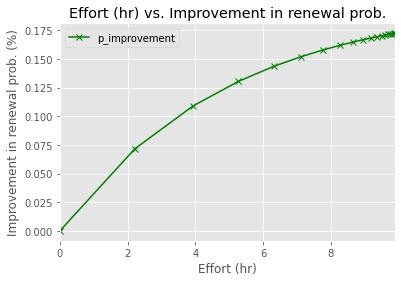

In [17]:
# --- 19. modeling % improvement in renewal prob, incentives, net_revenue ---
# Fig 1. Incentives ($) vs. Effort (hour):
I1 = np.arange(0,1900,100)
t1 = 10*(1-np.exp(-I1/400))

# Make a dataframe for incentives plan:
df_time = pd.DataFrame({'incentives':I1, 'time':t1})
# Make a plot: effort vs. incentives
df_time.plot(x='incentives', y='time', 
                   c='purple', marker='*')
plt.title(' Incentives vs. Effort (hr)')
plt.xlabel('Incentives ($)')
plt.ylabel('Effort (hr)')
plt.show()

# Fig 2. Effort (hour) vs % improvement in renewal prob:
t = t1;
p_improvement = 20*(1-np.exp(-t/5))/100

# Make a dataframe for improvement in renewal prob.:
df_renewal_imp = pd.DataFrame({'time':t, 'p_improvement':p_improvement})
# Make a plot: effort vs. incentives
df_renewal_imp.plot(x='time', y='p_improvement', 
                   c='green', marker='x')
plt.title('Effort (hr) vs. Improvement in renewal prob.')
plt.xlabel('Effort (hr)')
plt.ylabel('Improvement in renewal prob. (%)')
plt.show()

### Summary: Insurance Propensity Relationships
Relationship 1) Incentives vs. Effort (hr):
* With increase in incentives paid to sales agent, more hours are spent on collecting premiums.

Relationship 2) Effort (hr) vs. Improvement in renewal probability (%):
* With increase in effort (hours) spent on collecting premiums, % of improvement in renewal probabilities.

In [18]:
# Compute: pct_improvement_renewal_prob, incentives, net_revenue:
# Use the best model to make: predictions, probabilities for renewal
y_pred_best = df_pred
y_pred_prob_best = df_pred_probs[:,1]  

# Prepare basic metrics: p_benchmark, incentive:
#p_imp = ((1-p_benchmark)/p_benchmark)/100 # p_imp (% improvement prob. of renewal)

# random permuation of incentives:
i_range = np.arange(0,1840,1840/len(y_pred_best)) 
incentive = np.random.permutation(i_range) 

# % prob. of renewal:
p_benchmark = y_pred_prob_best.copy() 

# premiums on a test set:
premium = df_test_enc.iloc[:,7]

In [19]:
# Function 1: incentives to effort
def incentive_to_t(I):
    '''calculate efforts by a sales agent based on amount of incentives paid'''
    return 10*(1-np.exp(-I/400))

# Function 2: efforts to p_imp 
def t_to_p_imp(t):
    '''calculate % of improvement in renewal probabilities based on hours of effort by a sales agent'''
    return 20*(1-np.exp(-t/5))

# Function 3: calculate total net revenue
def net_revenue(p_benchmark, premium, p_imp, incentive):
    '''calculate the total net revenue based on benchmark, premium, % improvement in renewal and incentive given'''
    return (p_benchmark*premium*(1+p_imp)-incentive)

# Final model KPI metrics:
t = incentive_to_t(incentive) # calculated efforts invested by an agent
p_imp = t_to_p_imp(t) # calculated % improvement in prob. of renewal
net_rev = net_revenue(p_benchmark, premium, p_imp, incentive) # calculated net revenue on each policy

# Final Output:
# compute the KPI series:
series_id = pd.Series(df_test_id, name="id")
series_p_bench = pd.Series(p_benchmark, name="p_benchmark")
series_incentive = pd.Series(incentive, name="incentive")
series_net_rev = pd.Series(net_rev, name="net_revenue")

# concatenate and make output df:
output = pd.concat([series_id, series_p_bench, series_incentive, series_net_rev], axis=1)

# Print output head and total net revenue:
print(output.head())
print(output.tail())
print('Estimated total_net_revenue' + ' is %0.0f'% np.sum(net_rev))

# Save output for submission: id, p_benchmark, incentive
output.to_csv('incentive_results_best.csv', index=False, index_label=None)

      id  p_benchmark    incentive    net_revenue
0  33246     0.977726  1014.677419   93118.466316
1     96     0.987152   437.419355   83307.623596
2  47621     0.974746  1555.591398  131352.525932
3  82051     0.992920    27.150538   32953.633245
4  99791     0.996391  1630.376344  400947.342211
          id  p_benchmark    incentive    net_revenue
34219   6002     0.976674  1324.946237   99375.747095
34220  35157     0.722693  1707.204301  207614.058336
34221  50657     0.981953   555.860215  121291.310415
34222  41271     0.987765   431.451613  862519.687850
34223  33000     0.993097  1205.645161  245672.511075
Estimated total_net_revenue is 5619691859


### Summary: Revenue Optimization ###
Estimated total net revenue on this client population is around 5.63 Billions!